CAN ID: 0x180, Data: 41049ba640000000
VCU received: CAN ID: 0x180, Data: 41049ba640000000
CAN ID: 0x180, Data: 41048dff40000000
VCU received: CAN ID: 0x180, Data: 41048dff40000000
CAN ID: 0x180, Data: 4104805740000000
VCU received: CAN ID: 0x180, Data: 4104805740000000
CAN ID: 0x180, Data: 410472b040000000
VCU received: CAN ID: 0x180, Data: 410472b040000000
CAN ID: 0x180, Data: 4104650940000000
VCU received: CAN ID: 0x180, Data: 4104650940000000
CAN ID: 0x180, Data: 4104576240000000
VCU received: CAN ID: 0x180, Data: 4104576240000000
CAN ID: 0x180, Data: 410449ba40000000
VCU received: CAN ID: 0x180, Data: 410449ba40000000
CAN ID: 0x180, Data: 41043c1340000000
VCU received: CAN ID: 0x180, Data: 41043c1340000000
CAN ID: 0x180, Data: 41042e6c40000000
VCU received: CAN ID: 0x180, Data: 41042e6c40000000
CAN ID: 0x180, Data: 410420c540000000
VCU received: CAN ID: 0x180, Data: 410420c540000000
CAN ID: 0x180, Data: 4104131d40000000
VCU received: CAN ID: 0x180, Data: 4104131d40000000
CAN ID: 0x

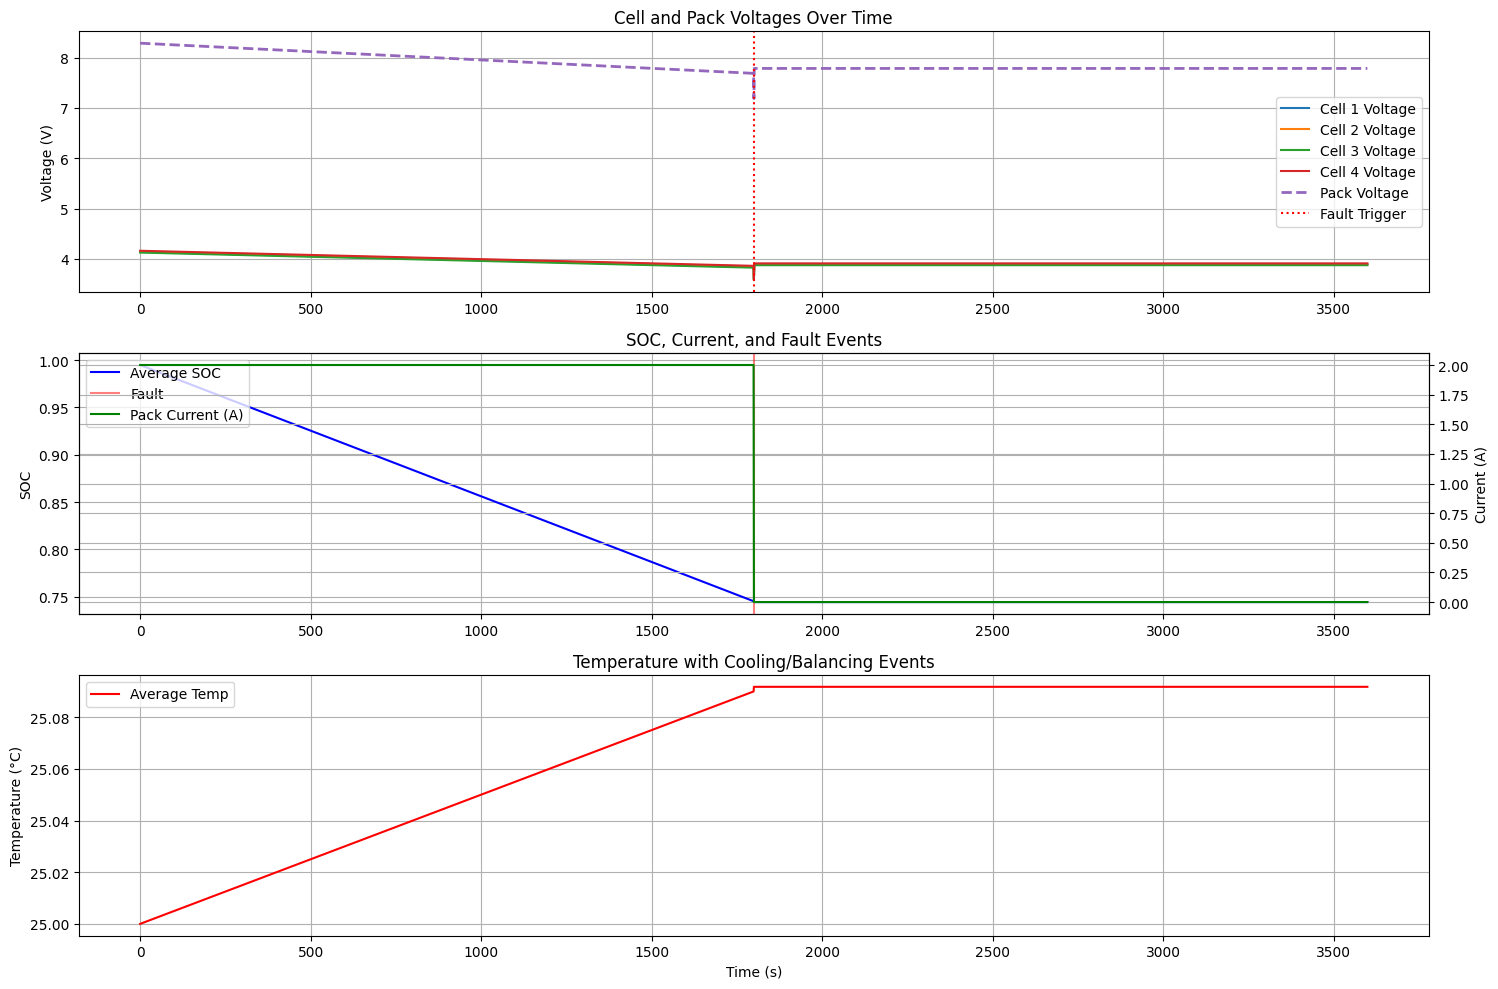


CAN Logs:
CAN ID: 0x180, Data: 41049ba640000000
CAN ID: 0x180, Data: 41048dff40000000
CAN ID: 0x180, Data: 4104805740000000
CAN ID: 0x180, Data: 410472b040000000
CAN ID: 0x180, Data: 4104650940000000
CAN ID: 0x180, Data: 4104576240000000
CAN ID: 0x180, Data: 410449ba40000000
CAN ID: 0x180, Data: 41043c1340000000
CAN ID: 0x180, Data: 41042e6c40000000
CAN ID: 0x180, Data: 410420c540000000
CAN ID: 0x180, Data: 4104131d40000000
CAN ID: 0x180, Data: 4104057640000000
CAN ID: 0x180, Data: 4103f7cf40000000
CAN ID: 0x180, Data: 4103ea2840000000
CAN ID: 0x180, Data: 4103dc8040000000
CAN ID: 0x180, Data: 4103ced940000000
CAN ID: 0x180, Data: 4103c13240000000
CAN ID: 0x180, Data: 4103b38b40000000
CAN ID: 0x180, Data: 4103a5e340000000
CAN ID: 0x180, Data: 4103983c40000000
CAN ID: 0x180, Data: 41038a9540000000
CAN ID: 0x180, Data: 41037cee40000000
CAN ID: 0x180, Data: 41036f4640000000
CAN ID: 0x180, Data: 4103619f40000000
CAN ID: 0x180, Data: 410353f840000000
CAN ID: 0x180, Data: 4103465140000000
C

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
import struct

# Battery Cell Class
class BatteryCell:
    def __init__(self, capacity_ah=2.0, r_int=0.05, initial_soc=1.0, initial_temp=25.0):
        self.capacity = capacity_ah * 3600  # in As (Ampere-seconds)
        self.soc = initial_soc
        self.r = r_int
        self.temp = initial_temp
        self.voltage = self.get_ocv()
        self.current = 0.0

    def get_ocv(self):
        # Simple linear OCV model: 3.0V at 0% SOC, 4.2V at 100% SOC
        return 3.0 + 1.2 * self.soc

    def update(self, current, dt):
        self.current = current
        # Update voltage with IR drop
        self.voltage = self.get_ocv() - current * self.r
        # Coulomb counting for SOC
        dq = current * dt
        self.soc -= dq / self.capacity
        # Simple heating model (I^2 * R loss)
        power_loss = current ** 2 * self.r
        # Arbitrary thermal capacity (J/°C), assume 1000 for sim
        c_thermal = 1000.0
        self.temp += (power_loss * dt) / c_thermal
        # Simple cooling if overtemp (fan simulation)
        if self.temp > 60:
            self.temp -= 0.01 * dt  # Arbitrary cooling rate

# BMS Class for 2s2p pack
class BMS:
    def __init__(self):
        # Create 4 cells for 2s2p (slight imbalance in initial SOC)
        self.cells = [
            BatteryCell(initial_soc=0.99),  # Cell 1
            BatteryCell(initial_soc=1.00),  # Cell 2
            BatteryCell(initial_soc=0.98),  # Cell 3
            BatteryCell(initial_soc=1.01)   # Cell 4
        ]
        self.pack_voltage = 0.0
        self.pack_current = 0.0
        self.avg_soc = 0.0
        self.avg_temp = 0.0
        self.faults = []
        # Thresholds
        self.v_max = 4.2
        self.v_min = 2.5
        self.t_max = 60.0
        self.t_min = 0.0
        self.i_max = 5.0  # Per branch current
        self.imbalance_threshold = 0.1

    def update_pack(self, total_current, dt):
        # For 2s2p: 2 parallel branches, each with 2 series cells
        # Assume current splits equally (simplification)
        branch_current = total_current / 2.0
        for i in range(0, 4, 2):  # Update branches
            self.cells[i].update(branch_current, dt)
            self.cells[i+1].update(branch_current, dt)

        # Calculate pack voltage (series: sum of one branch, assume balanced)
        self.pack_voltage = self.cells[0].voltage + self.cells[1].voltage
        self.pack_current = total_current
        self.avg_soc = np.mean([cell.soc for cell in self.cells])
        self.avg_temp = np.mean([cell.temp for cell in self.cells])

        # Voltage-based SOC estimate (average from OCV)
        avg_ocv = np.mean([(cell.voltage + branch_current * cell.r) for cell in self.cells])
        soc_voltage = (avg_ocv - 3.0) / 1.2
        # Combined SOC: average of coulomb and voltage
        self.avg_soc = (self.avg_soc + soc_voltage) / 2.0

    def detect_faults(self):
        self.faults = []
        cell_voltages = [cell.voltage for cell in self.cells]
        cell_temps = [cell.temp for cell in self.cells]
        branch_current = self.pack_current / 2.0

        # Over/undervoltage
        if any(v > self.v_max for v in cell_voltages):
            self.faults.append("overvoltage")
        if any(v < self.v_min for v in cell_voltages):
            self.faults.append("undervoltage")

        # Over/undertemp
        if any(t > self.t_max for t in cell_temps):
            self.faults.append("overtemp")
        if any(t < self.t_min for t in cell_temps):
            self.faults.append("undertemp")

        # Overcurrent (per branch)
        if abs(branch_current) > self.i_max:
            self.faults.append("overcurrent")

        # Imbalance
        if max(cell_voltages) - min(cell_voltages) > self.imbalance_threshold:
            self.faults.append("imbalance")

        return self.faults

    def handle_faults(self):
        if "overcurrent" in self.faults or "overvoltage" in self.faults or "undervoltage" in self.faults:
            print("Shutdown triggered!")
            self.pack_current = 0.0  # Simulate shutdown
        if "overtemp" in self.faults:
            print("Cooling activated!")
            # Cooling already in cell update
        if "imbalance" in self.faults:
            print("Balancing activated!")
            # Simple balancing: discharge highest voltage cell
            max_v_idx = np.argmax([cell.voltage for cell in self.cells])
            balance_current = 0.1  # Small balancing current
            self.cells[max_v_idx].soc -= (balance_current * dt) / self.cells[max_v_idx].capacity

# Simple CAN Simulation
class CANBus:
    def __init__(self):
        self.logs = []

    def send_message(self, bms, fault_code=0):
        # CAN ID 0x180, data: pack_v (float), pack_i (float), soc (uint8 %), temp (uint8 °C), fault (uint8)
        pack_v = bms.pack_voltage
        pack_i = bms.pack_current
        soc_pct = int(bms.avg_soc * 100)
        temp_c = int(bms.avg_temp)
        data = struct.pack('>ffBB', pack_v, pack_i, soc_pct, temp_c) + struct.pack('>B', fault_code)
        # Truncate to 8 bytes (struct gives more, but simulate)
        data = data[:8]
        msg = f"CAN ID: 0x180, Data: {data.hex()}"
        print(msg)
        self.logs.append(msg)

    def vcu_receive(self, msg):
        print(f"VCU received: {msg}")

# Simulation
bms = BMS()
can = CANBus()
dt = 1.0  # seconds per step
sim_time = 3600  # 1 hour sim
times = []
pack_voltages = []
avg_socs = []
avg_temps = []
fault_list = []

# Normal operation
load_current = 2.0  # A (total pack)
for t in range(sim_time // 2):
    times.append(t)
    bms.update_pack(load_current, dt)
    faults = bms.detect_faults()
    bms.handle_faults()
    fault_list.append(faults)
    pack_voltages.append(bms.pack_voltage)
    avg_socs.append(bms.avg_soc)
    avg_temps.append(bms.avg_temp)
    # Send CAN every 10 steps
    if t % 10 == 0:
        fault_code = 1 if faults else 0
        can.send_message(bms, fault_code)
        can.vcu_receive(can.logs[-1])

# Induce fault: overcurrent
print("\nInducing fault: high current\n")
load_current = 12.0  # Overcurrent
for t in range(sim_time // 2, sim_time):
    times.append(t)
    bms.update_pack(load_current, dt)
    faults = bms.detect_faults()
    bms.handle_faults()
    load_current = bms.pack_current  # Update if shutdown
    fault_list.append(faults)
    pack_voltages.append(bms.pack_voltage)
    avg_socs.append(bms.avg_soc)
    avg_temps.append(bms.avg_temp)
    if t % 10 == 0:
        fault_code = 1 if faults else 0
        can.send_message(bms, fault_code)
        can.vcu_receive(can.logs[-1])

# Plots
# Detailed Plots
%matplotlib inline
plt.figure(figsize=(15, 10))

# Plot 1: Individual Cell Voltages and Pack Voltage
plt.subplot(3, 1, 1)
for i, voltages in enumerate(cell_voltages):
    plt.plot(times, voltages, label=f'Cell {i+1} Voltage')
plt.plot(times, pack_voltages, label='Pack Voltage', linewidth=2, linestyle='--')
plt.axvline(x=1800, color='r', linestyle=':', label='Fault Trigger')
plt.ylabel('Voltage (V)')
plt.title('Cell and Pack Voltages Over Time')
plt.legend()
plt.grid(True)

# Plot 2: SOC, Current, and Fault Indicators
plt.subplot(3, 1, 2)
ax1 = plt.gca()  # Get current axis for SOC
ax1.plot(times, avg_socs, label='Average SOC', color='b')
ax1.set_ylabel('SOC')
ax1.grid(True)

ax2 = ax1.twinx()  # Create a second y-axis for current
ax2.plot(times, currents, label='Pack Current (A)', color='g')
ax2.set_ylabel('Current (A)')
ax2.grid(True)

for t, faults in enumerate(fault_list):
    if faults:
        ax1.axvline(x=t, color='r', alpha=0.5, label='Fault' if t == fault_list.index(faults) else "")
plt.title('SOC, Current, and Fault Events')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 3: Temperature with Cooling/Balancing Indicators
plt.subplot(3, 1, 3)
plt.plot(times, avg_temps, label='Average Temp', color='r')
for t, faults in enumerate(fault_list):
    if "overtemp" in faults:
        plt.axvspan(t-1, t+1, color='yellow', alpha=0.3, label='Cooling' if t == [i for i, f in enumerate(fault_list) if "overtemp" in f][0] else "")
    if "imbalance" in faults:
        plt.axvspan(t-1, t+1, color='cyan', alpha=0.3, label='Balancing' if t == [i for i, f in enumerate(fault_list) if "imbalance" in f][0] else "")
plt.ylabel('Temperature (°C)')
plt.xlabel('Time (s)')
plt.title('Temperature with Cooling/Balancing Events')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print CAN logs
print("\nCAN Logs:")
for log in can.logs:
    print(log)

In [9]:
pip install numpy matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ----------------- ---------------------- 5.5/12.8 MB 28.4 MB/s eta 0:00:01
   ----------------------------- ---------- 9.4/12.8 MB 23.4 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.8 MB 21.7 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 20.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------ --------------------- 3.7/8.1 MB 17.5 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 17.3 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 13.2 MB/s


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
